In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import fsolve
from  scipy import interpolate
from py_vollib_vectorized.models import vectorized_black_scholes
from py_vollib_vectorized.api import get_all_greeks
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility
from py_vollib_vectorized.api import price_dataframe
from statsmodels.tsa.stattools import adfuller

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
# %matplotlib widget

In [146]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [147]:
df = pd.read_csv("../data/training_pricepaths.csv", index_col=0)
df.head()

,underlying,call65,call70,call75,call80,call85,call90,call95,call100,call105,...,put90,put95,put100,put105,put110,put115,put120,put125,put130,put135
0,100.000000,35.436537,30.436449,25.465460,20.544501,15.718957,11.091298,6.883928,3.493461,1.333979,...,1.091298,1.883928,3.493461,6.333979,10.375479,15.090290,20.025352,25.011182,30.008593,35.010526
1,99.703351,35.117638,30.116325,25.143759,20.221087,15.395046,10.773197,6.591873,3.268877,1.212482,...,1.069846,1.888522,3.565526,6.509131,10.632709,15.380026,20.322307,25.309459,30.307651,35.311125
2,99.781739,35.246585,30.252950,25.291467,20.385660,15.585513,11.000335,6.856841,3.536347,1.409663,...,1.218595,2.075101,3.754608,6.627924,10.649909,15.334966,20.254847,25.235405,30.231430,35.233703
3,99.989922,35.412877,30.423416,25.464844,20.560375,15.759372,11.169538,7.013417,3.664809,1.492569,...,1.179616,2.023495,3.674888,6.502648,10.479730,15.139596,20.050467,25.028339,30.023364,35.024824
4,99.348765,34.765348,29.783212,24.834189,19.944124,15.167839,10.623611,6.550014,3.329964,1.305116,...,1.274847,2.201250,3.981199,6.956351,11.042635,15.753561,20.681516,25.664342,30.660513,35.661443


# Preliminary Time Series Analysis

In [148]:
df['underlying'].plot()

<Axes3D: title={'center': 'Call Option Theta'}, xlabel='Strike Price', ylabel='Time to Expiry', zlabel='Theta'>

In [149]:
np.log(df['underlying']).hist(bins=50,density=True)

<Axes3D: title={'center': 'Call Option Theta'}, xlabel='Strike Price', ylabel='Time to Expiry', zlabel='Theta'>

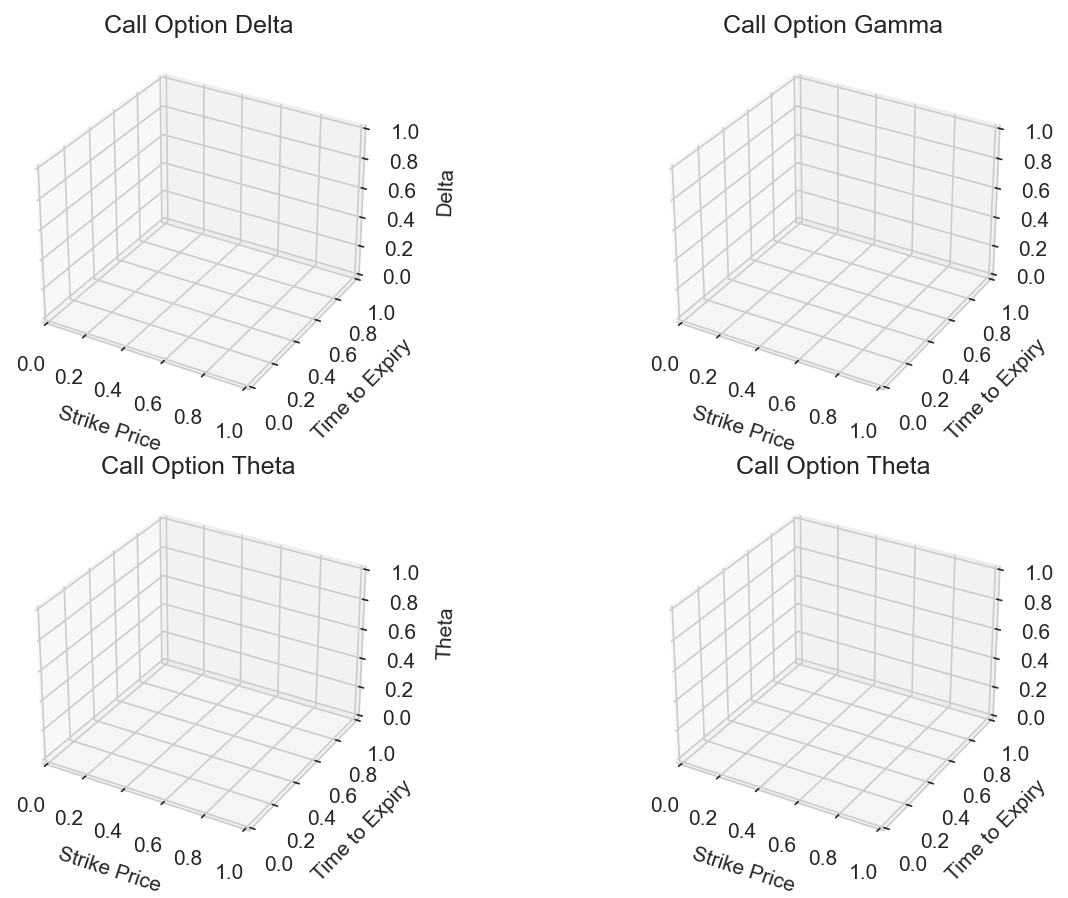

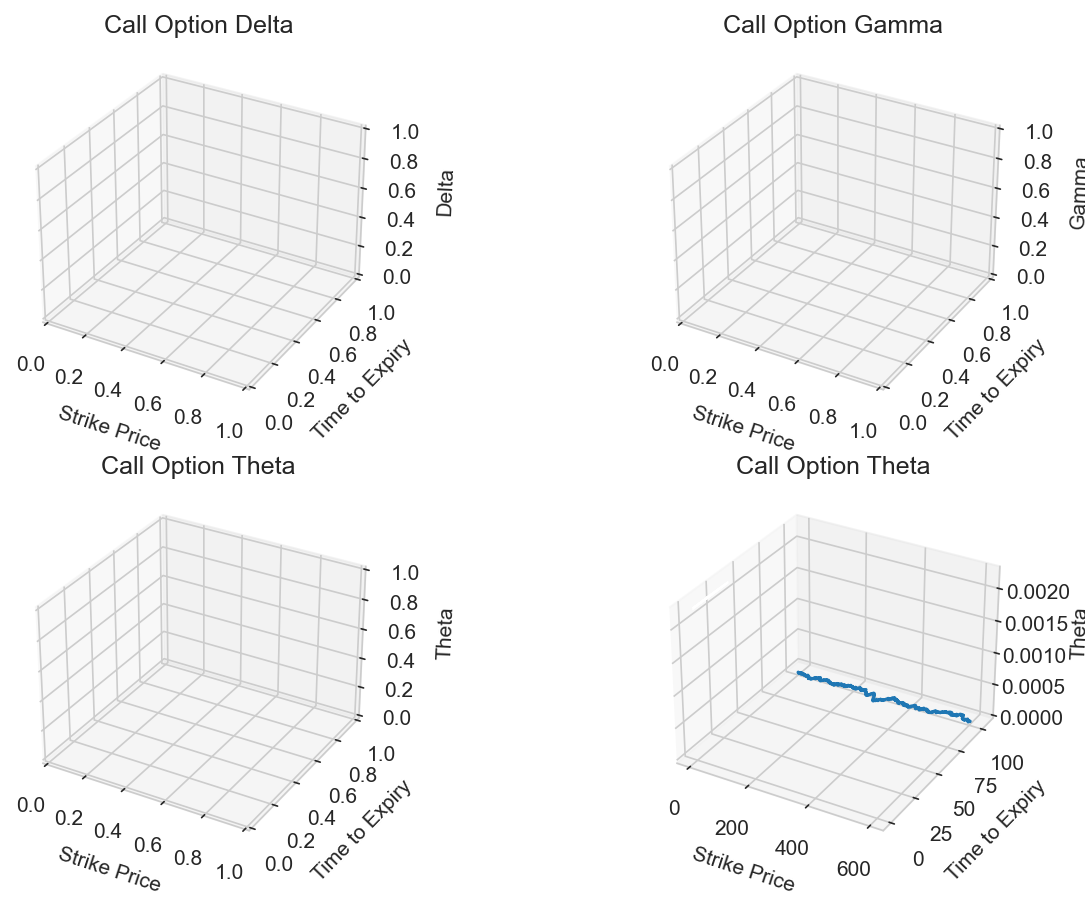

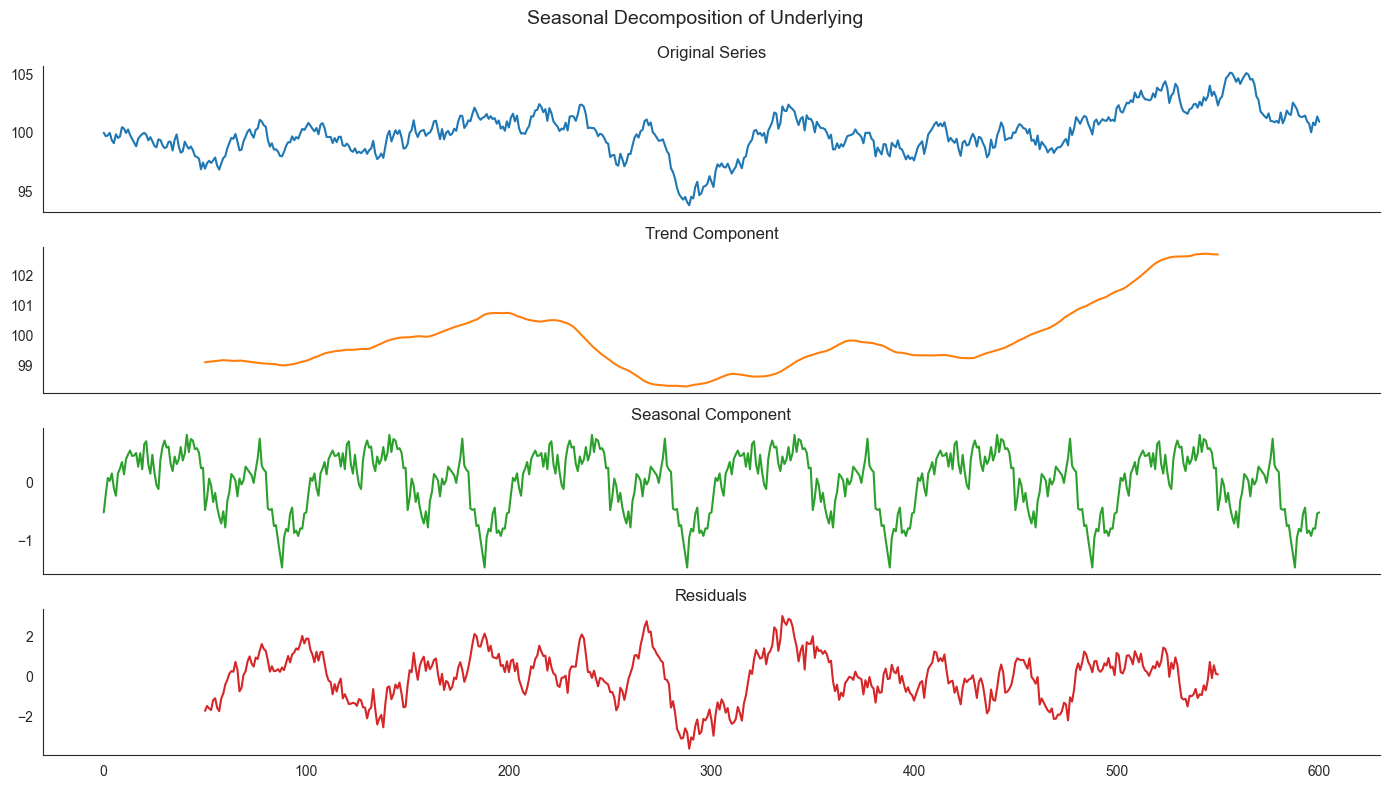

In [150]:
df_underlying = df[['underlying']]
components_underlying = tsa.seasonal_decompose(df_underlying['underlying'], model='additive', period=100)
ts_pearls = (df_underlying['underlying'].to_frame('Original')
      .assign(Trend=components_underlying.trend)
      .assign(Seasonality=components_underlying.seasonal)
      .assign(Residual=components_underlying.resid))
with sns.axes_style('white'):
    ts_pearls.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition of Underlying', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [151]:
pd.DataFrame(components_underlying.seasonal).idxmin()

No such comm: f577be7a8e4a4eefae007ae780d422ac


seasonal    88
dtype: int64

c:\Users\redce\Documents\cs-stuff\uchicago-trading-2023\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


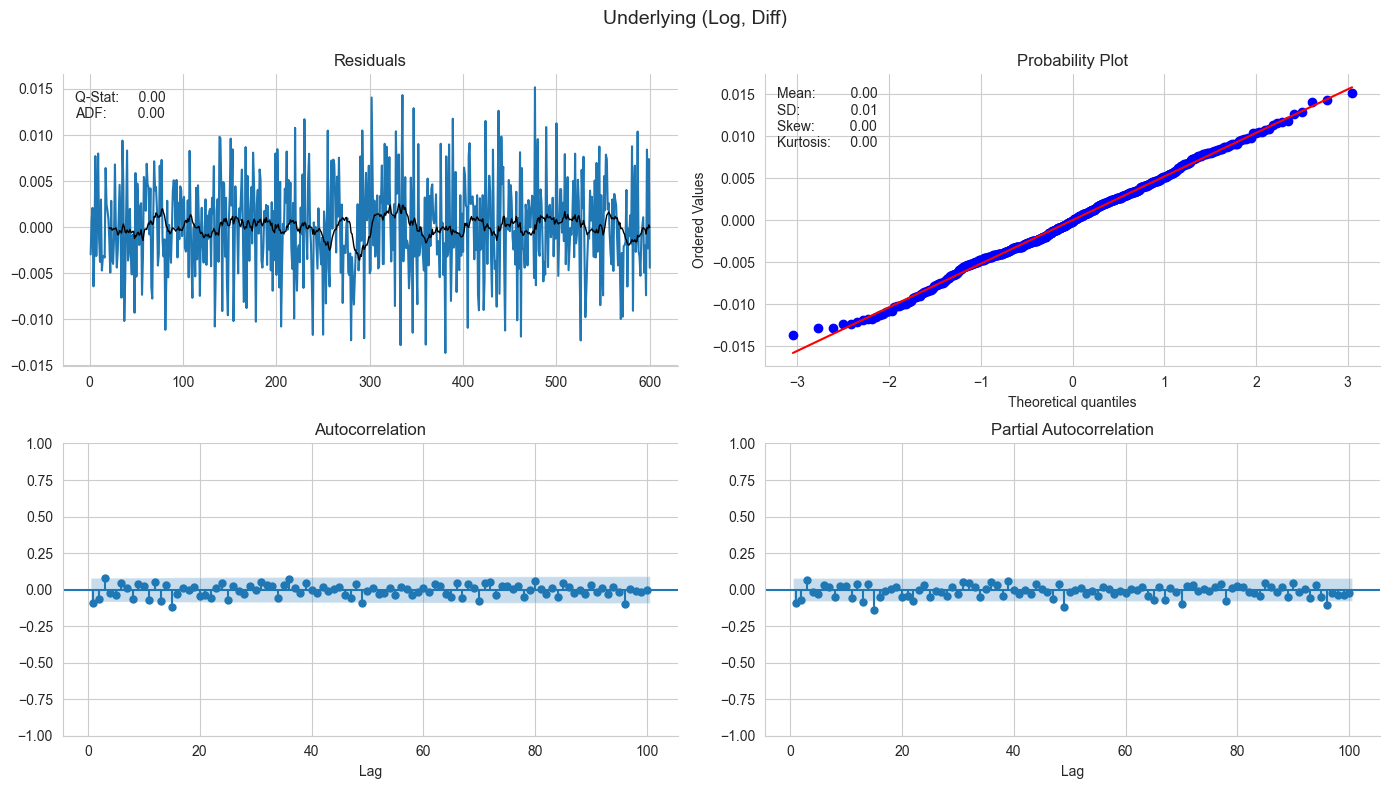

In [152]:
underlying_log = np.log(df_underlying['underlying'])
underlying_log_diff = underlying_log.diff().dropna()

# plot_correlogram(df_underlying['underlying'], lags=100, title='Underlying (Log, Diff)')
plot_correlogram(underlying_log_diff, lags=100, title='Underlying (Log, Diff)')

In [153]:
res = adfuller(df_underlying['underlying'])
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -3.055788
p-value: 0.030003
critical values at different levels:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [154]:
# size = (5,4)
# for i in df.columns:
#     # df[[i]].plot(figsize=size)
#     df[[i]].hist(figsize=size, bins=50)

# Single Strike Implied Volatility

In [155]:
df_call65 = df[['underlying','call65']]

In [156]:
df_call65['time_to_expiry'] = np.linspace(0.25,1/12,601)

C:\Users\redce\AppData\Local\Temp\ipykernel_26156\2039022776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_call65['time_to_expiry'] = np.linspace(0.25,1/12,601)


In [157]:
cimpl_vol = []
for i in range(len(df_call65)):
    price = df_call65['call65'][i]
    S = df_call65['underlying'][i]
    K = 65
    t = df_call65['time_to_expiry'][i]
    r = 0
    flag = 'c'
    cimpl_vol.append(vectorized_implied_volatility(price, S, K, t, r, flag, q=0, return_as='numpy')[0])

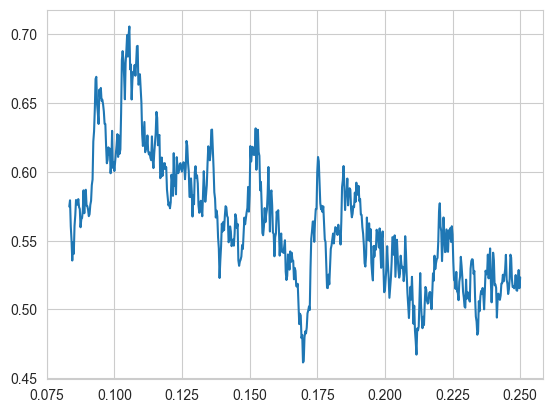

In [158]:
plt.plot(df_call65['time_to_expiry'],cimpl_vol)

# Implied Volatility Surfaces

In [159]:
df['time_to_expiry'] = np.linspace(0.25,1/12,601)
cimpl_vol = np.zeros((len(df),len(range(65,140,5))))

In [160]:
for i in range(len(df)):
    for j in range(65,140,5):
        price = df[f'call{j}'][i]
        S = df['underlying'][i]
        K = j
        t = df['time_to_expiry'][i]
        r = 0
        flag = 'c'
        cimpl_vol[i][int((j/5) - 13)] = vectorized_implied_volatility(price, S, K, t, r, flag, q=0, return_as='numpy')[0]

In [161]:
cimpl_df = pd.DataFrame(cimpl_vol, columns=[f'CIV{i}' for i in range(65,140,5)])
cimpl_df

,CIV65,CIV70,CIV75,CIV80,CIV85,CIV90,CIV95,CIV100,CIV105,CIV110,CIV115,CIV120,CIV125,CIV130,CIV135
0,0.523355,0.446913,0.380012,0.322176,0.273039,0.232310,0.199757,0.175192,0.158460,0.149432,0.148000,0.154072,0.167568,0.188423,0.216577
1,0.515440,0.439233,0.372665,0.315283,0.266737,0.226750,0.195102,0.171613,0.156133,0.148541,0.148731,0.156618,0.172124,0.195185,0.225745
2,0.528684,0.452670,0.386174,0.328725,0.279960,0.239593,0.207392,0.183172,0.166779,0.158085,0.156982,0.163379,0.177198,0.198373,0.226844
3,0.520800,0.446925,0.382272,0.326382,0.278899,0.239543,0.208091,0.184361,0.168201,0.159489,0.158119,0.164003,0.177065,0.197238,0.224468
4,0.513607,0.441283,0.377984,0.323251,0.276728,0.238134,0.207243,0.183871,0.167868,0.159107,0.157483,0.162905,0.175297,0.194592,0.220732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.535585,0.464772,0.402626,0.348669,0.302531,0.263923,0.232612,0.208408,0.191157,0.180728,0.177014,0.179923,0.189375,0.205302,0.227647
597,0.550550,0.477839,0.414014,0.358593,0.311202,0.271550,0.239404,0.214574,0.196906,0.186270,0.182559,0.185681,0.195558,0.212122,0.235316
598,0.560427,0.485549,0.419852,0.362842,0.314141,0.273448,0.240525,0.215178,0.197249,0.186604,0.183133,0.186743,0.197352,0.214892,0.239303
599,0.579381,0.500437,0.431084,0.370791,0.319150,0.275842,0.240611,0.213251,0.193593,0.181497,0.176844,0.179537,0.189488,0.206627,0.230889


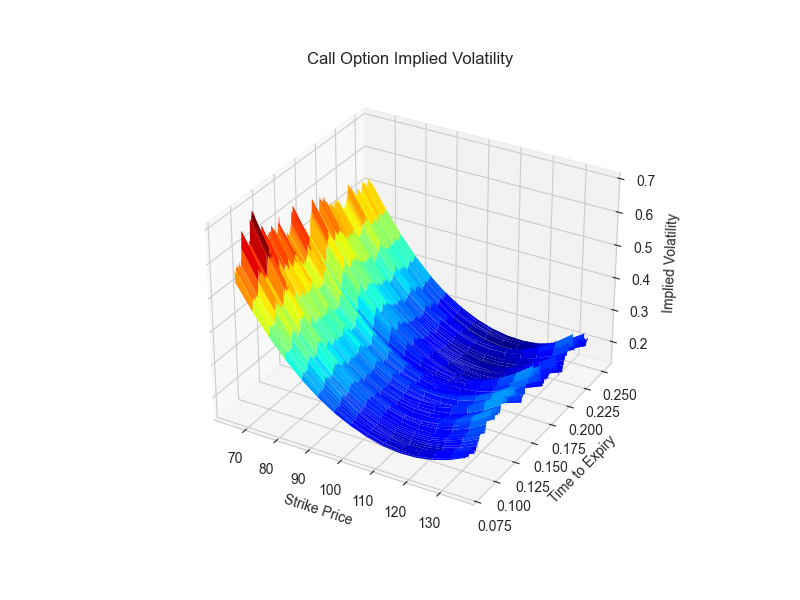

In [163]:
%matplotlib widget
x,y = np.meshgrid(range(65,140,5), df['time_to_expiry'])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Call Option Implied Volatility")
ax.set_ylabel('Time to Expiry')
ax.set_xlabel('Strike Price')
ax.set_zlabel('Implied Volatility')
ax.plot_surface(x, y, cimpl_df, cmap=plt.cm.jet, antialiased=True, rcount=200, ccount=200, linewidth=0)

In [164]:
# %matplotlib inline

# Options Greeks Surfaces

In [165]:
df

,underlying,call65,call70,call75,call80,call85,call90,call95,call100,call105,...,put95,put100,put105,put110,put115,put120,put125,put130,put135,time_to_expiry
0,100.000000,35.436537,30.436449,25.465460,20.544501,15.718957,11.091298,6.883928,3.493461,1.333979,...,1.883928,3.493461,6.333979,10.375479,15.090290,20.025352,25.011182,30.008593,35.010526,0.250000
1,99.703351,35.117638,30.116325,25.143759,20.221087,15.395046,10.773197,6.591873,3.268877,1.212482,...,1.888522,3.565526,6.509131,10.632709,15.380026,20.322307,25.309459,30.307651,35.311125,0.249722
2,99.781739,35.246585,30.252950,25.291467,20.385660,15.585513,11.000335,6.856841,3.536347,1.409663,...,2.075101,3.754608,6.627924,10.649909,15.334966,20.254847,25.235405,30.231430,35.233703,0.249444
3,99.989922,35.412877,30.423416,25.464844,20.560375,15.759372,11.169538,7.013417,3.664809,1.492569,...,2.023495,3.674888,6.502648,10.479730,15.139596,20.050467,25.028339,30.023364,35.024824,0.249167
4,99.348765,34.765348,29.783212,24.834189,19.944124,15.167839,10.623611,6.550014,3.329964,1.305116,...,2.201250,3.981199,6.956351,11.042635,15.753561,20.681516,25.664342,30.660513,35.661443,0.248889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,100.032705,35.043239,30.047080,25.055534,20.076258,15.133960,10.312569,5.876522,2.432486,0.601069,...,0.843816,2.399781,5.568363,10.044239,14.972941,19.967656,24.967330,29.967303,34.967299,0.084444
597,100.878248,35.889777,30.893417,25.901330,20.920246,15.971332,11.125318,6.606533,2.957641,0.838377,...,0.728284,2.079392,4.960129,9.253432,14.134146,19.122762,24.121870,29.121781,34.121768,0.084167
598,100.644919,35.659095,30.663181,25.672049,20.693025,15.748823,10.914257,6.423055,2.829666,0.781541,...,0.778136,2.184747,5.136623,9.473957,14.366037,19.355988,24.355194,29.355112,34.355101,0.083889
599,101.390634,36.407339,31.410827,26.418535,21.436438,16.482656,11.616822,7.032380,3.233859,0.935217,...,0.641746,1.843225,4.544583,8.753137,13.621763,18.610260,23.609462,28.609390,33.609381,0.083611


In [166]:
cdelta = np.zeros((len(df),len(range(65,140,5))))
cgamma = np.zeros((len(df),len(range(65,140,5))))
ctheta = np.zeros((len(df),len(range(65,140,5))))
cvega = np.zeros((len(df),len(range(65,140,5))))

for i in range(len(df)):
    for j in range(65,140,5):
        sigma = cimpl_df[i:i+1][f'CIV{j}']
        S = df['underlying'][i]
        K = j
        t = df['time_to_expiry'][i]
        r = 0
        flag = 'c'
        res = get_all_greeks(flag, S, K, t, r, sigma, model='black_scholes', return_as='dict')
        cdelta[i][int((j/5) - 13)] = res['delta'][0]
        cgamma[i][int((j/5) - 13)] = res['gamma'][0]
        ctheta[i][int((j/5) - 13)] = res['theta'][0]
        cvega[i][int((j/5) - 13)] = res['vega'][0]

In [167]:
cdelta_df = pd.DataFrame(cdelta, columns=[f'CDELTA{i}' for i in range(65,140,5)])
cdelta_df

,CDELTA65,CDELTA70,CDELTA75,CDELTA80,CDELTA85,CDELTA90,CDELTA95,CDELTA100,CDELTA105,CDELTA110,CDELTA115,CDELTA120,CDELTA125,CDELTA130,CDELTA135
0,0.962222,0.956173,0.946200,0.928644,0.895931,0.832764,0.713451,0.517467,0.282244,0.107808,0.032036,0.009951,0.004378,0.003093,0.003292
1,0.963249,0.957392,0.947592,0.930058,0.896815,0.831538,0.706909,0.503286,0.266184,0.099063,0.029834,0.009946,0.004858,0.003775,0.004267
2,0.960388,0.953619,0.942565,0.923343,0.888120,0.821748,0.700520,0.508719,0.284230,0.115975,0.038259,0.013198,0.006178,0.004388,0.004507
3,0.963005,0.956357,0.945479,0.926541,0.891820,0.826414,0.707047,0.517914,0.294485,0.123300,0.041586,0.014357,0.006539,0.004440,0.004355
4,0.962775,0.955485,0.943542,0.922750,0.884716,0.813606,0.686024,0.489884,0.268047,0.106868,0.034168,0.011212,0.004904,0.003251,0.003171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.997799,0.996644,0.994134,0.987972,0.971040,0.921668,0.787409,0.514231,0.199148,0.037349,0.003627,0.000275,0.000029,0.000006,0.000003
597,0.997685,0.996588,0.994264,0.988726,0.973936,0.931595,0.815711,0.568121,0.250646,0.057642,0.007197,0.000698,0.000088,0.000022,0.000011
598,0.997237,0.996002,0.993420,0.987358,0.971436,0.926620,0.806041,0.553421,0.237945,0.052886,0.006437,0.000630,0.000084,0.000022,0.000013
599,0.996905,0.995764,0.993450,0.988203,0.974818,0.937482,0.834110,0.600561,0.275292,0.063418,0.007394,0.000641,0.000074,0.000018,0.000010


In [168]:
cgamma_df = pd.DataFrame(cgamma, columns=[f'CGAMMA{i}' for i in range(65,140,5)])
cgamma_df

,CGAMMA65,CGAMMA70,CGAMMA75,CGAMMA80,CGAMMA85,CGAMMA90,CGAMMA95,CGAMMA100,CGAMMA105,CGAMMA110,CGAMMA115,CGAMMA120,CGAMMA125,CGAMMA130,CGAMMA135
0,0.003143,0.004153,0.005753,0.008459,0.013234,0.021557,0.034079,0.045500,0.042651,0.024805,0.009708,0.003445,0.001533,0.000998,0.000919
1,0.003132,0.004145,0.005766,0.008542,0.013510,0.022269,0.035388,0.046656,0.042200,0.023551,0.009140,0.003400,0.001643,0.001157,0.001116
2,0.003245,0.004305,0.005981,0.008786,0.013642,0.021842,0.033614,0.043693,0.040794,0.024786,0.010623,0.004165,0.001976,0.001302,0.001166
3,0.003111,0.004146,0.005790,0.008553,0.013347,0.021449,0.033114,0.043311,0.041066,0.025613,0.011269,0.004455,0.002076,0.001321,0.001141
4,0.003193,0.004296,0.006062,0.009036,0.014177,0.022721,0.034536,0.043761,0.039596,0.023354,0.009706,0.003647,0.001636,0.001020,0.000879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.000444,0.000749,0.001424,0.003088,0.007514,0.019071,0.042930,0.065810,0.050253,0.015512,0.002109,0.000195,0.000022,0.000005,0.000002
597,0.000449,0.000735,0.001348,0.002819,0.006645,0.016598,0.038007,0.062600,0.055219,0.021175,0.003738,0.000445,0.000061,0.000015,0.000007
598,0.000520,0.000837,0.001508,0.003089,0.007134,0.017465,0.039195,0.063030,0.053813,0.019825,0.003390,0.000404,0.000058,0.000015,0.000008
599,0.000554,0.000850,0.001454,0.002831,0.006284,0.015211,0.035312,0.061772,0.058820,0.023377,0.003945,0.000425,0.000054,0.000013,0.000007


In [169]:
ctheta_df = pd.DataFrame(ctheta, columns=[f'CTHETA{i}' for i in range(65,140,5)])
ctheta_df

,CTHETA65,CTHETA70,CTHETA75,CTHETA80,CTHETA85,CTHETA90,CTHETA95,CTHETA100,CTHETA105,CTHETA110,CTHETA115,CTHETA120,CTHETA125,CTHETA130,CTHETA135
0,-0.011739,-0.011313,-0.011341,-0.011997,-0.013499,-0.015945,-0.018666,-0.019183,-0.014696,-0.007574,-0.002892,-0.001106,-0.000580,-0.000477,-0.000579
1,-0.011275,-0.010841,-0.010865,-0.011532,-0.013074,-0.015599,-0.018382,-0.018763,-0.014031,-0.007061,-0.002733,-0.001121,-0.000652,-0.000590,-0.000761
2,-0.012315,-0.011984,-0.012126,-0.012920,-0.014570,-0.017113,-0.019761,-0.020050,-0.015503,-0.008436,-0.003548,-0.001499,-0.000833,-0.000687,-0.000805
3,-0.011500,-0.011293,-0.011548,-0.012448,-0.014205,-0.016867,-0.019680,-0.020218,-0.015941,-0.008912,-0.003836,-0.001623,-0.000878,-0.000692,-0.000774
4,-0.011332,-0.011264,-0.011670,-0.012738,-0.014667,-0.017436,-0.020100,-0.020059,-0.015110,-0.007979,-0.003232,-0.001293,-0.000669,-0.000513,-0.000568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,-0.001654,-0.002111,-0.003035,-0.004984,-0.009239,-0.018073,-0.031948,-0.039505,-0.025219,-0.006815,-0.000860,-0.000079,-0.000010,-0.000002,-0.000001
597,-0.001798,-0.002226,-0.003089,-0.004890,-0.008779,-0.016905,-0.030428,-0.040505,-0.029970,-0.010109,-0.001665,-0.000198,-0.000029,-0.000008,-0.000005
598,-0.002152,-0.002611,-0.003542,-0.005469,-0.009571,-0.017970,-0.031544,-0.040828,-0.029159,-0.009443,-0.001509,-0.000181,-0.000028,-0.000009,-0.000006
599,-0.002490,-0.002862,-0.003654,-0.005306,-0.008816,-0.016130,-0.028817,-0.039872,-0.031200,-0.010716,-0.001665,-0.000178,-0.000024,-0.000007,-0.000004


In [170]:
cvega_df = pd.DataFrame(cvega, columns=[f'CVEGA{i}' for i in range(65,140,5)])
cvega_df

,CVEGA65,CVEGA70,CVEGA75,CVEGA80,CVEGA85,CVEGA90,CVEGA95,CVEGA100,CVEGA105,CVEGA110,CVEGA115,CVEGA120,CVEGA125,CVEGA130,CVEGA135
0,0.041125,0.046391,0.054648,0.068108,0.090287,0.125131,0.170137,0.199280,0.168850,0.092512,0.035976,0.013404,0.006532,0.004783,0.005037
1,0.040068,0.045186,0.053336,0.066832,0.089413,0.125275,0.171344,0.198762,0.163438,0.086697,0.033810,0.013348,0.007128,0.005684,0.006316
2,0.042604,0.048394,0.057353,0.071705,0.094808,0.129904,0.173096,0.198767,0.168873,0.097168,0.041443,0.017015,0.008800,0.006494,0.006632
3,0.040357,0.046152,0.055129,0.069518,0.092688,0.127933,0.171614,0.198917,0.171981,0.101615,0.044403,0.018312,0.009263,0.006573,0.006443
4,0.040279,0.046567,0.056274,0.071732,0.096327,0.132855,0.175788,0.197666,0.163176,0.091147,0.037590,0.014712,0.007146,0.004951,0.004827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.002015,0.002948,0.004854,0.009109,0.019213,0.042510,0.084344,0.115894,0.081110,0.023700,0.003208,0.000314,0.000039,0.000010,0.000005
597,0.002123,0.003013,0.004790,0.008670,0.017719,0.038587,0.077895,0.115047,0.093079,0.033765,0.005900,0.000735,0.000110,0.000030,0.000016
598,0.002480,0.003458,0.005387,0.009536,0.019047,0.040563,0.080072,0.115248,0.090143,0.031424,0.005330,0.000666,0.000105,0.000031,0.000018
599,0.002762,0.003662,0.005396,0.009033,0.017246,0.036050,0.072991,0.113219,0.097832,0.036442,0.006055,0.000682,0.000095,0.000025,0.000015


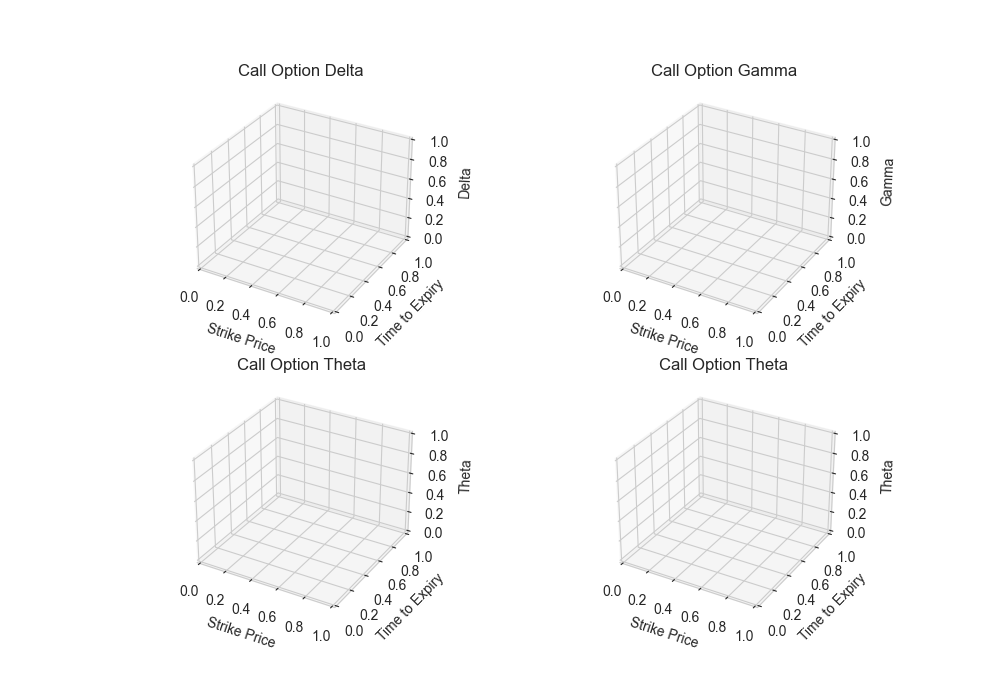

In [171]:
%matplotlib widget

x,y = np.meshgrid(range(65,140,5), df['time_to_expiry'])
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig2 = plt.figure(figsize=(10, 7))

ax1 = fig2.add_subplot(221, projection='3d')
ax1.set_title("Call Option Delta")
ax1.set_ylabel('Time to Expiry')
ax1.set_xlabel('Strike Price')
ax1.set_zlabel('Delta')
ax.plot_surface(x, y, cdelta_df, cmap=plt.cm.jet, antialiased=True, rcount=200, ccount=200, linewidth=0)

ax2 = fig2.add_subplot(222, projection='3d')
ax2.set_title("Call Option Gamma")
ax2.set_ylabel('Time to Expiry')
ax2.set_xlabel('Strike Price')
ax2.set_zlabel('Gamma')
ax.plot_surface(x, y, cgamma_df, cmap=plt.cm.jet, antialiased=True, rcount=200, ccount=200, linewidth=0)

ax3 = fig2.add_subplot(223, projection='3d')
ax3.set_title("Call Option Theta")
ax3.set_ylabel('Time to Expiry')
ax3.set_xlabel('Strike Price')
ax3.set_zlabel('Theta')
ax.plot_surface(x, y, ctheta_df, cmap=plt.cm.jet, antialiased=True, rcount=200, ccount=200, linewidth=0)

ax4 = fig2.add_subplot(224, projection='3d')
ax4.set_title("Call Option Theta")
ax4.set_ylabel('Time to Expiry')
ax4.set_xlabel('Strike Price')
ax4.set_zlabel('Theta')
ax.plot_surface(x, y, cvega_df, cmap=plt.cm.jet, antialiased=True, rcount=200, ccount=200, linewidth=0)